In [114]:
base_url = "..\\experiment(Jupyter)_artifacts\\"
dataset_folder_path = "built_dataset"
train_file_name = "train.csv"
feature_engineering_artifacts_folder = "Feature_Engineering"
TARGET_FEATURE = "Time_taken"
useless_features = ['ID', 'Delivery_person_ID']
MAX_UNIQUE_VALUES_FOR_DISCRETE_FEATURES = 25
validation_file = "validation.csv"
tensorboard_logdir = "tensorboard_logs"
pipeline_file_name = 'pipeline.joblib'
test_dataset_file = "test.csv"

# Loading Libraries

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from typing import List
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

# Creating the paths and folders

In [116]:
train_file_path = os.path.join(base_url,dataset_folder_path,train_file_name)

In [117]:
validation_file_path = os.path.join(base_url,dataset_folder_path,validation_file)

In [118]:
pipeline_file_path = os.path.join(base_url,pipeline_file_name)

# Preprocess Classes

In [119]:
class DropUndersiredFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=['ID', 'Delivery_person_ID']):
        
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self  # nothing to do

    def transform(self, X, y=None):
        df = X.copy()
        for feature in self.features_to_drop:
            ## try and catch to avoid run time errors
            try:
                df.drop(feature, axis=1, inplace=True)
            except:
                pass

        return df

## Imputing Numerical features class

class ImputeNumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numerical_features_nan = []
        self.medians = []
        
    def fit(self,X,y=None):
        try:
            ### Numerical features having null features
            
            self.numerical_features_nan = [feature for feature in X.columns if X[feature].dtypes !='O' and X[feature].isnull().sum()>=1]
        
            self.medians = []
            for feature in self.numerical_features_nan:
                self.medians.append(X[feature].median())
        except:
            pass
        
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        for index, feature in enumerate(self.numerical_features_nan):

            try:
                median_value = self.medians[index]
                ## create new feature to capture nan values
                df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
                ### replace the missing values with median
                df[feature] = df[feature].fillna(median_value)

            except:
                pass
        return df
        
class ImputeCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_features = []  # empty categorical features list

    def fit(self, X, y=None):
        try:
            # Get the categorical features
            self.categorical_features = [feature for feature in X.columns if X[feature].dtype == 'O']
        except:
            pass

        return self

    def transform(self, X, y=None):
        ## standardize the features
        df = X.copy()
        try:
            for feature in self.categorical_features:
                df[feature] = df[feature].str.lower()
        except:
            pass

        ## Handle missing values
        try:
            df[self.categorical_features] = df[self.categorical_features].fillna('missing')

        except:
            pass

        return df
class ExtractFromTemporalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, temporal_features = ['Order_Date', 'Time_Order_picked', 'Time_Orderd']):
        
        self.temporal_features = temporal_features
    
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X, y = None):
        df = X.copy()
        
        try:
            ## Working on Order Date
            df[self.temporal_features[0]+"_Day"] = df[self.temporal_features[0]].str.split('-').str[0].astype(int)
            df[self.temporal_features[0]+"_Month"] = df[self.temporal_features[0]].str.split('-').str[1].astype(int)
            
            
            
            ### Working on Time Order Picked
            df[self.temporal_features[1]+"_Hr"] = df[self.temporal_features[1]].str.split(':').str[0].astype(int)
            df[self.temporal_features[1]+"_Min"] = df[self.temporal_features[1]].str.split(':').str[1].astype(int)
            
            df.drop(self.temporal_features, axis = 1, inplace = True)
            
            return df
        except Exception as e:
            print(str(e))
        
        
class GenerateDistanceFromLatitudeAndLongitude(BaseEstimator,TransformerMixin):
    def __init__(self,distance_features = ['Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']):
        self.distance_features = distance_features
    
    def fit(self,X,y=None):
        #print('fit')
        return self
    
    def transform(self,X,y=None):
        df = X.copy()
        #print('transform')
        try:
            ## Convert features to radians
            for feature in self.distance_features:
                df[feature] = np.radians(df[feature])
                
            lat1 = df[self.distance_features[0]]
            lon1 = df[self.distance_features[1]]
            
            lat2 = df[self.distance_features[2]]
            lon2 = df[self.distance_features[3]]
            
            
            newlon = lon2 - lon1
            newlat = lat2 - lat1
            
            haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
            
            dist = 2 * np.arcsin(np.sqrt(haver_formula ))
            
            km = 6367 * dist #6367 for distance in KM for miles use 3958

            df['Distance'] = km
            
            
            
            return df
         
        except Exception as e:
            print(str(e))
        
        
class Label_Encode(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_features = ['Festival','Road_traffic_density']):
        self.ordinal_features = ordinal_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        try:
            #print(df[self.ordinal_features])
            df['Festival'] = df['Festival'].map({'no':0,'yes':1,'missing':0})
            df['Road_traffic_density']=df['Road_traffic_density'].map({'low':0,'medium' : 1,'high' : 2,'jam':3,'missing' : 0})
            
            
            return df
        except:
            print(str(e))

class OHE_Categorical_Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_features = []
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    def fit(self, X, y=None):
        try:
            self.categorical_features = [feature for feature in X.columns if X[feature].dtype == 'O']
            self.ohe.fit(X[self.categorical_features])
            ##print(self.ohe.categories_)
        except:
            pass

        return self

    def transform(self, X, y=None):
        df = X.copy()
        try:
            cat_ohe = self.ohe.transform(df[self.categorical_features])

            ohe_df = pd.DataFrame(cat_ohe, columns=self.ohe.get_feature_names(input_features=self.categorical_features),
                                  index=df.index)
            df = pd.concat([df, ohe_df], axis=1).drop(columns=self.categorical_features, axis=1)
        except Exception as e:
            pass

        return df


class remove_high_corelated_features(BaseEstimator, TransformerMixin):
    @staticmethod
    ## We set a corelation threshold (probably 0.85)
    ## We iterate on corelation matrix and see if 2 features have this much or greater corelation.
    ## If they have, we will remove one of the features.

    def get_high_correlation_feature(dataset, threshold):
        col_corr = set() ## set of column names to be dropped
        corr_matrix = dataset.corr()

        for i in range(len(corr_matrix.columns)-1,-1,-1):
            for j in range(i-1,-1,-1):
                if abs(corr_matrix.iloc[i,j]) > threshold:
                    colname = corr_matrix.columns[i] ## getting the column name
                    #print(corr_matrix.columns[i],"-----" ,corr_matrix.columns[j], "====", corr_matrix.iloc[i,j])
                    col_corr.add(colname)
        return(col_corr)
            
    
    def __init__(self, threshold = 0.85):
        self.correlated_features = []
        self.threshold = threshold
    
    def fit(self,X,y=None):
        self.correlated_features= remove_high_corelated_features.get_high_correlation_feature(X,self.threshold)
        
        return self
        
    def transform(self,X,y=None):
        df = X.copy()
        
        for feature in self.correlated_features:
            try:
                df.drop(feature,axis = 1, inplace= True)
            except:
                continue
        return df

In [161]:
preprocess_pipeline = Pipeline([
    ('drop_undesired_features',DropUndersiredFeatures()),
    ('impute_numerical_features',ImputeNumericalFeatures()),
    ('impute_categorical_features', ImputeCategoricalFeatures()),
    ('label_encode',Label_Encode()),
    ('extract_temporal_features', ExtractFromTemporalFeatures()),
    ('OHE', OHE_Categorical_Features()),
    ('generate_distance', GenerateDistanceFromLatitudeAndLongitude()),
    
    
    ('remove_correlated_features',remove_high_corelated_features()),
    ('scaler', StandardScaler())
    
])

# Loading the data

In [162]:
train_df = pd.read_csv(train_file_path)

In [163]:
validation_df = pd.read_csv(validation_file_path)

In [164]:
X_train,y_train = train_df.drop(TARGET_FEATURE, axis = 1), train_df[TARGET_FEATURE]

In [165]:
X_validation , y_validation = validation_df.drop(TARGET_FEATURE, axis = 1), validation_df[TARGET_FEATURE]

In [166]:
preprocess_pipeline.fit(X_train)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Pipeline(steps=[('drop_undesired_features', DropUndersiredFeatures()),
                ('impute_numerical_features', ImputeNumericalFeatures()),
                ('impute_categorical_features', ImputeCategoricalFeatures()),
                ('label_encode', Label_Encode()),
                ('extract_temporal_features', ExtractFromTemporalFeatures()),
                ('OHE', OHE_Categorical_Features()),
                ('generate_distance',
                 GenerateDistanceFromLatitudeAndLongitude()),
                ('remove_correlated_features',
                 remove_high_corelated_features()),
                ('scaler', StandardScaler())])

In [167]:
X_train_transformed = preprocess_pipeline.transform(X_train)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [168]:
X_train_transformed

array([[ 0.42271121,  0.50048117, -0.47899005, ..., -0.16472582,
        -0.05913702, -0.07980056],
       [-0.63090209,  0.80628026,  0.69921889, ..., -0.16472582,
        -0.05913702, -0.08825718],
       [-1.68451539,  0.50048117,  0.04990999, ..., -0.16472582,
        -0.05913702, -0.0812949 ],
       ...,
       [ 0.42271121, -0.41691611,  0.24333348, ..., -0.16472582,
        -0.05913702, -0.08684763],
       [ 0.07150677,  0.19468208, -2.0772266 , ..., -0.16472582,
        -0.05913702, -0.0754058 ],
       [ 0.07150677,  0.19468208, -0.49638511, ..., -0.16472582,
        -0.05913702, -0.08678714]])

In [169]:
X_validation_transformed = preprocess_pipeline.transform(X_validation)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [170]:
distance = X_train_transformed[:,1]

In [171]:
#distance = X_train_transformed['Distance']

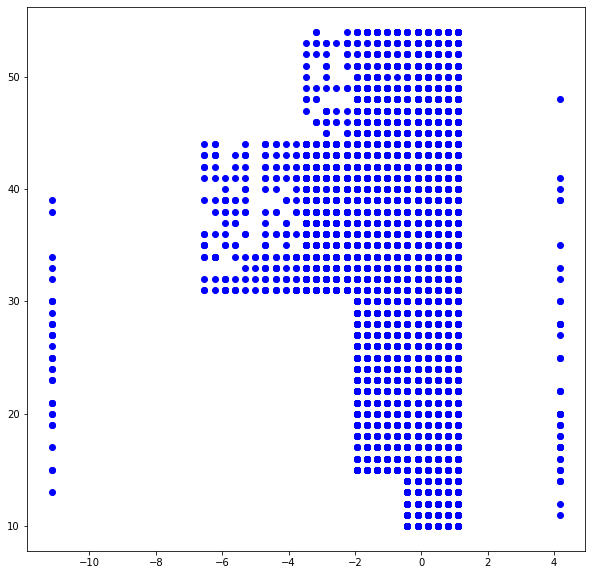

In [172]:
plt.figure(figsize=(10,10))
plt.plot(distance,y_train,'bo')

In [132]:
distance.reshape(-1,1)

array([[ 0.50048117],
       [ 0.80628026],
       [ 0.50048117],
       ...,
       [-0.41691611],
       [ 0.19468208],
       [ 0.19468208]])

In [133]:
from sklearn.cluster import KMeans

In [134]:
kmeans = KMeans()

In [135]:
kmeans.fit(distance.reshape(-1,1))

KMeans()

In [136]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [137]:
silhouette_score

<function sklearn.metrics.cluster._unsupervised.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)>

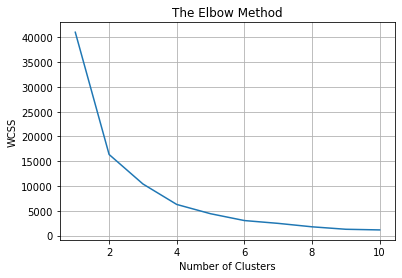

In [138]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(distance.reshape(-1,1))
    #kmeans.fit(X_train_transformed)
    #labels = kmeans.predict(distance.reshape[-1,1])
    
    #print(f"For no of clusters : {i} , sil score is {silhouette_score(X_train_transformed,labels)}")
    
    wcss.append(kmeans.inertia_)


plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [139]:
kmeans=KMeans(n_clusters=2, init='k-means++',random_state=0)
kmeans.fit(X_train_transformed)

KMeans(n_clusters=2, random_state=0)

In [140]:
kmeans.predict(X_train_transformed)

array([0, 1, 0, ..., 1, 1, 1])

In [141]:
cluster = 0
train_labels = kmeans.predict(X_train_transformed)
train_indices = np.where(train_labels == cluster)

In [142]:
cluster_X_train_transformed = X_train_transformed[train_indices]

In [143]:
train_indices[0].shape

(17328,)

In [144]:
cluster_y_train_transformed = np.array(y_train)[train_indices]


In [145]:
validation_labels = kmeans.predict(X_validation_transformed)

In [146]:
validation_indices = np.where(validation_labels == cluster)

In [147]:
cluster_X_validation_transformed = X_validation_transformed[validation_indices]
cluster_y_validation_transformed = np.array(y_validation)[validation_indices]

In [148]:
from sklearn.ensemble import RandomForestRegressor

In [149]:
rf = RandomForestRegressor(n_estimators=1200,min_samples_split=6, bootstrap=False, max_features='log2')


In [150]:
rf.fit(cluster_X_train_transformed,cluster_y_train_transformed)

RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_split=6,
                      n_estimators=1200)

In [151]:
predictions_train = rf.predict(cluster_X_train_transformed)
predictions_validation = rf.predict(cluster_X_validation_transformed)

In [152]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(cluster_y_train_transformed,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(cluster_y_validation_transformed,predictions_validation))
r2_train = r2_score(cluster_y_train_transformed,predictions_train)
r2_validation = r2_score(cluster_y_validation_transformed,predictions_validation)

In [154]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.7002387747411087			0.9617598850860654
Validation		4.6953823285685345			0.7086898476520451


In [155]:
class custom_model:
    def __init__(self,num_clusters = 4):
        self.num_clusters = num_clusters
        self.models = []
        self.kmeans = None
    
    def fit(self,X,y):
        self.kmeans=KMeans(n_clusters=self.num_clusters, init='k-means++',random_state=0)
        
        ## Doing clustering
        self.kmeans.fit(X)
        
        train_labels = self.kmeans.predict(X)
        print(train_labels)
        
        print(len(train_labels[train_labels==0]))
        print(len(train_labels[train_labels==1]))
        print(len(train_labels[train_labels==2]))
        
        ## Creating models
        for i in range(self.num_clusters):
            
            
            train_indices = np.where(train_labels == i)
            
            
            X_transformed = X[train_indices]
        
            y_transformed = np.array(y_train)[train_indices]
            
            rf = RandomForestRegressor()
            rf.fit(X_transformed,y_transformed)
            
            self.models.append(rf)
            
    def predict(self,X):
        predictions = [None for i in range(len(X))]
        
        clusters = self.kmeans.predict(X)
        
        for i in range(self.num_clusters):
            
            
            indices = np.where(clusters == i)[0]
            
            X_transformed = X[indices]
            
            current_model = self.models[i]
            
            current_predictions = current_model.predict(X_transformed)
            
            for j in range(len(indices)):
                predictions[indices[j]] = current_predictions[j]
            
        return predictions

In [156]:
model = custom_model()

In [157]:
model.fit(X_train_transformed,y_train)

[0 2 0 ... 2 3 2]
12476
3165
21737


In [158]:
predictions_train = model.predict(X_train_transformed)
predictions_validation = model.predict(X_validation_transformed)

In [159]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [160]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.8568221999642602			0.9608205642111617
Validation		4.922803595638167			0.7262827778516858


# After clustering, we still didn't get good results. Will go with random forest

In [56]:
from sklearn.model_selection import GridSearchCV


In [57]:
parameters = {
    "n_estimators":[100,500,1000,1200,1500],
    
    'min_samples_split':[2,4,6,8],
    'max_features':['int','sqrt','log2'],
    'bootstrap':[True,False],
}

In [58]:
grid = GridSearchCV(rf, parameters,cv=3,verbose=10,n_jobs=-1, scoring='r2')

In [60]:
grid.fit(X_train_transformed,y_train)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
134 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\rachi\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\rachi\anaconda3\lib\site-packages\

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['int', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 500, 1000, 1200, 1500]},
             scoring='r2', verbose=10)

In [61]:
grid.best_score_

0.8195443237616056

In [62]:
grid.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'n_estimators': 1200}

In [63]:
model = grid.best_estimator_

In [65]:
model.fit(X_train_transformed,y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=6,
                      n_estimators=1200)

In [66]:
predictions_train = model.predict(X_train_transformed)
predictions_validation = model.predict(X_validation_transformed)

In [67]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [68]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.359989509451414			0.9789821322709498
Validation		3.8910389918286845			0.8289952116700087


# Final Training on complete dataset and predictions

In [76]:
X_complete = np.concatenate([X_train_transformed,X_validation_transformed])

In [86]:
y_complete = pd.concat([y_train,y_validation])

In [87]:
model = grid.best_estimator_

In [89]:
model.fit(X_complete,y_complete)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=6,
                      n_estimators=1200)

In [94]:
test_dataset_file_path = os.path.join(base_url,dataset_folder_path,test_dataset_file)

In [95]:
test_df = pd.read_csv(test_dataset_file_path)

In [96]:
test_df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
0,0x2318,COIMBRES13DEL01,NaN,NaN,11.003669,76.976494,11.043669,77.016494,30-03-2022,NaN,15:05,NaN,NaN,3,Drinks,electric_scooter,1.0,No,Metropolitian
1,0x3474,BANGRES15DEL01,28.0,4.6,12.975377,77.696664,13.085377,77.806664,29-03-2022,20:30,20:35,Windy,Jam,0,Snack,motorcycle,1.0,No,Metropolitian
2,0x9420,JAPRES09DEL03,23.0,4.5,26.911378,75.789034,27.001378,75.879034,10-03-2022,19:35,19:45,Stormy,Jam,0,Drinks,motorcycle,1.0,No,Metropolitian
3,0x72ee,JAPRES07DEL03,21.0,4.8,26.766536,75.837333,26.856536,75.927333,02-04-2022,17:15,17:20,Fog,Medium,1,Meal,scooter,1.0,No,Metropolitian
4,0xa759,CHENRES19DEL01,31.0,4.6,12.986047,80.218114,13.096047,80.328114,27-03-2022,18:25,18:40,Sunny,Medium,2,Drinks,scooter,1.0,No,Metropolitian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11394,0x6909,JAPRES01DEL01,35.0,4.6,26.905190,75.810753,27.015190,75.920753,27-03-2022,21:35,21:45,Sunny,Jam,1,Snack,scooter,1.0,No,Metropolitian
11395,0x443b,JAPRES11DEL01,33.0,4.9,26.902940,75.793007,26.912940,75.803007,11-03-2022,11:40,11:45,Sandstorms,High,1,Drinks,scooter,1.0,No,Metropolitian
11396,0x1ea5,SURRES11DEL03,NaN,NaN,21.157735,72.768778,21.217735,72.828778,11-03-2022,NaN,21:05,NaN,NaN,3,Drinks,scooter,1.0,No,Metropolitian
11397,0x22d4,VADRES03DEL02,27.0,4.7,22.320000,73.170000,22.450000,73.300000,06-03-2022,18:35,18:40,Sandstorms,Medium,0,Meal,motorcycle,0.0,No,Metropolitian


In [97]:
test_df.shape

(11399, 19)

In [98]:
IDs = test_df.ID

In [100]:
test_transform_array = preprocess_pipeline.transform(test_df)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [103]:
predictions = model.predict(test_transform_array)

In [104]:
predictions

array([28.53054167, 30.41591667, 30.15138889, ..., 27.41431944,
       28.64211111, 23.47280556])

In [108]:
final_result = pd.DataFrame()

In [109]:
final_result['ID'] = IDs

In [110]:
final_result['Time_taken (min)'] = predictions

In [113]:
final_result.to_csv('result.csv',index=False)